# Lab 06 &mdash; $\chi^2$-test and non-parametric methods &mdash; solution tips


**Please enter in the cell below your first name, last name, and student ID**

In [46]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

1. Consider the A/B testing data for the cookie cat game. Establish with a two-sided U test at level $0.05$ if there is a significant difference in the number of played game rounds (column `sum_gamerounds`) between the two versions of the game. To do so, draw a sample of 200 observations for each version of the game

In [13]:
# code for exercise 1
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)
df_cookie = pd.read_csv("cookie_cats.csv")
print(df_cookie.head())
n = 200
game_rounds = df_cookie.sum_gamerounds.sample(n)
ver_30 = df_cookie.version.str.contains('gate_30')
ver_40 = df_cookie.version.str.contains('gate_40')
version_30 = ver_30.sample(n)
version_40 = ver_40.sample(n)
U_stat, p_val = stats.mannwhitneyu(game_rounds,ver_30,alternative='two-sided')
print("p-value for version with gate_30: "+str(p_val))
U_stat1, p_val1 = stats.mannwhitneyu(game_rounds,ver_40,alternative='two-sided')
print("p-value for version with gate_40: "+str(p_val1))
# solution tips

# load cookie_cats.csv into a pandas dataframe
# to sample observations from a particular version of the game,
#   first, you need to filter the dataframe to select all entries with that particular version
#   second, you sample the filtered dataframe (the other way round wouldn't work)


# then you simply use the mann whitney u test function on the two samples
#   and compare the p-value with the given level of 0.05

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
p-value for version with gate_30: 4.4473438884877047e-144
p-value for version with gate_40: 8.903697965750166e-144


2. Using the *CDC's Behavioral Risk Factor Surveillance System (BRFSS) survey* dataset, establish whether there is a significant association between gender and smoking, using a $\chi^2$ test at level $0.05$ and a sample of 500 participants. Print to screen also the value of the test statistic and the p-value

In [21]:
# code for exercise 2
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)
df_cdc = pd.read_csv("cdc.csv")
random_cdc = df_cdc.sample(500)
print(random_cdc.head())
table = pd.crosstab(index=random_cdc.gender, columns=random_cdc.smoke100)
table
print("------------------")
chi2, p_val, dof, exp_counts = stats.chi2_contingency(table, correction=False)
print("the value of the test statistic is "+str(chi2)+". p value is: "+str(p_val))
print("Degrees of freedom: "+str(dof))
# solution tips
# you just need to 1) draw a random sample of the cdc dataset
# 2) generate the contigency table with the appropriate variables
# 3) apply the chi-square function
# 4) compare the p-value with the given level of 0.05
# this code is a simple adaptation of the one in the notebook

         genhlth  exerany  hlthplan  smoke100  height  weight  wtdesire  age  \
10650  excellent        1         1         0      64     118       118   76   
2041   excellent        1         1         0      62     165       165   88   
8668   excellent        0         1         0      73     165       180   26   
1114        fair        0         1         1      67     180       160   80   
13902       good        0         1         1      71     170       170   64   

      gender  
10650      f  
2041       m  
8668       m  
1114       m  
13902      m  
------------------
the value of the test statistic is 7.045877981245304. p value is: 0.007944787145235391
Degrees of freedom: 1


3. By adapting the code of the `sign_test` function (see lab notebook), define a function that performs hypothesis testing about any percentile (not just the median). Evaluate your function on a random sample of 100 observations from the `sum_gamerounds` variable of the cookie cat game. Compute the p-value for a two-sided test that the true 37% percentile is equal to 37.
    * the function should take in input three arguments: `sample`, `null_value`, and `q`, where `q` is the desired percentile (between 0 and 100)
    * so, the null hypothesis is that the true `q`-th percentile is `null_value`
    * _tip_: you'll just need to modify the distribution under the null

In [43]:
# code for exercise 3
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)
sample_size = 100
game_rounds1 = df_cookie.sum_gamerounds.sample(sample_size)
def sign_test(sample, q, m0=0):
    n = sample.size
    p=np.percentile(sample,1-(q/100))
    h0_distr = stats.binom(n=n, p=p)
    num_wins = np.sum(sample>m0)
    num_ties = np.sum(sample==m0)
    # random tie resolution corresponds to drawing
    # a coin (a 0.5 bernoulli) for each tie, i.e., 
    # drawing one binomial observation with parameters 
    # n=num_ties and p=0.5
    stat_val = num_wins + stats.binom(n=num_ties, p=p).rvs(1)
    left_tail_p = h0_distr.cdf(stat_val)
    # as usual, for discrete vars, P(X>=x)=1-P(X<x))=1-P(X<=x-1) 
    right_tail_p = 1 - h0_distr.cdf(stat_val-1)
    p_val=2*np.min([left_tail_p,right_tail_p])
    return stat_val, p_val

stat_val, p_val = sign_test(game_rounds1, 37)
print("Test statistic value: "+str(stat_val))
print("p-value: "+str(p_val))
# solution tips

# the modified function is essentially the same as the function sign_test in the notebook.
# the only two things to change are: 1) add an extra argument for the percentile, and 
# 2) change the null distribution variable h0_distr, noting that the probability 
#   of each observation being above the q-th percentile is 1 - q/100 (and not q/100)

Test statistic value: [98]
p-value: 0.0


4. Perform the same test of question 3, but use bootstrap sampling. I.e., draw a random sample of 100 observations from the `sum_gamerounds` variable. By resampling this sample, generate a bootstrap distribution for the 37-th percentile. Use $B=2000$ bootstrap samples. Finally, apply the shifting method to derive the null distribution and compute the p-value.
    * _tip_: percentiles can be computed using the `np.percentile` function, see lab notebook and https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

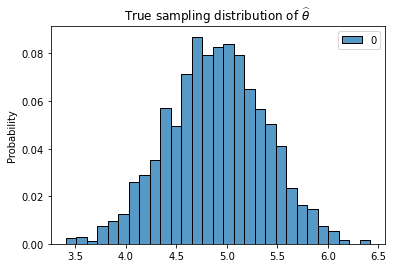

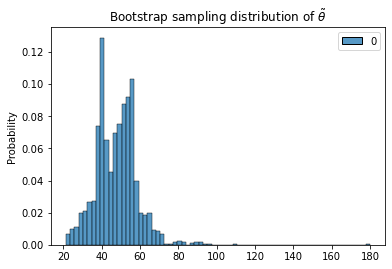

In [49]:
# code for exercise 4
# fix random seed so that results are reproducible (do not change)
np.random.seed(42)
pop_distr = stats.uniform(scale=10)
my_stat = lambda sample : stats.iqr(sample)
sample_num = 2000

# initialize a numpy array of size (sample_num, 1) to store the sample statistics
theta_hats = np.empty([sample_num, 1])

# draw the samples by calling the rvs function
for i in range(sample_num):
    # apply our statistic function to a random sample drawn from the pop distr
    theta_hats[i] = my_stat(pop_distr.rvs(sample_size))
    
sns.histplot(theta_hats, stat='probability')
plt.title('True sampling distribution of $\widehat{\\theta}$')
plt.show()   

# now let's compute the bootstrap proxy of the sampling distribution
# by resampling our sample (the only thing we know)

# let's define a useful function handle for resampling
# rng is numpy's random number generator
rng = np.random.default_rng()
resample = lambda sample, n : rng.choice(a=sample,size=n)

# draw bootstrap samples, and store corresponding statistic values
theta_tildes = np.empty([sample_num, 1])

for i in range(sample_num):
    # apply our statistic function to a bootstrap resample drawn from the given sample
    theta_tildes[i] = my_stat(resample(sample=game_rounds1, n=sample_size))

# plot the bootstrap sampling distribution
sns.histplot(theta_tildes, stat='probability')
plt.title('Bootstrap sampling distribution of $\\tilde{\\theta}$')
plt.show()
# solution tips

# the code here is essentially the same code of the notebook with just a couple of minor changes

# 1) draw a random sample
# 2) define your statistic (e.g. by adapting the code of `my_stat` lambda function, see notebook)
# 3) evaluate statistic on sample, obtaining your theta_hat_est
# 4) draw 2000 bootstrap resamples of the sample, and for each compute the statistic (same code of notebook)
# 5) derive the null distribution with the shifting method and compute p-value 
#    (same code of notebook, just need to change the null value)